In [12]:
import pennylane as qml
from pennylane import numpy as npp
from matplotlib import pyplot as plt

# set the random seed
npp.random.seed(42)

# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift", interface="autograd")
def circuit(params,inputs):
    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)
    qml.RY(inputs[2], wires=2)
    qml.RY(inputs[3], wires=3)
    

    qml.U3(params[0],params[1],params[2], wires=0)
    qml.U3(params[3],params[4],params[5], wires=1)
    qml.U3(params[6],params[7],params[8], wires=2)
    qml.U3(params[9],params[10],params[11], wires=3)
    

    qml.broadcast(qml.CNOT, wires=[0, 1, 2,3], pattern="ring")
    '''
    qml.RY(inputs[0]*1.5, wires=0)
    qml.RY(inputs[1]*1.5, wires=1)
    qml.RY(inputs[2]*1.5, wires=2)
    qml.RY(inputs[3]*1.5, wires=3)
'''
    qml.U3(params[12],params[13],params[14], wires=0)
    qml.U3(params[15],params[16],params[17], wires=1)
    qml.U3(params[18],params[19],params[20], wires=2)
    qml.U3(params[21],params[22],params[23], wires=3)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2,3], pattern="ring")
    
    '''
    qml.RY(inputs[0]*2, wires=0)
    qml.RY(inputs[1]*2, wires=1)
    qml.RY(inputs[2]*2, wires=2)
    qml.RY(inputs[3]*2, wires=3)
'''
    qml.U3(params[24],params[25],params[26], wires=0)
    qml.U3(params[27],params[28],params[29], wires=1)
    qml.U3(params[30],params[31],params[32], wires=2)
    qml.U3(params[33],params[34],params[35], wires=3)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2, 3], pattern="ring")
    
    #return qml.expval(qml.PauliX(0) @ qml.PauliI(1)@ qml.PauliY(2)@ qml.PauliI(3))
    return qml.expval(qml.PauliX(0) @  qml.PauliY(2))

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split 
import scipy.stats as stats
import math

def norminv(x):
    return ((1.0/math.sqrt(2.0*math.pi)) * math.exp(-x*x*0.5))

def d1(S0, K, r, T, sigma, q):
    deno = (sigma * math.sqrt(T))
    if (deno==0):
        return 0
    logReturns = math.log(S0/float(K)) if ((S0/float(K)) > 0.0) else 0.0
    return (float(logReturns) + (float(r) - float(q) + float(sigma)*float(sigma)*0.5)*float(T)) / float(deno)
    
def d2(S0, K, r, T, sigma, q):
        return d1(S0, K, r, T, sigma, q)-sigma*math.sqrt(T)
        
def bsformula(callput, S0, K, r, T, sigma, q=0):
    N = stats.norm.cdf
                
    def optionValueOfCall(S0, K, r, T, sigma, q):       
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return S0*math.exp(-q*T)*N(_d1)- K*math.exp(-r*T)*N(_d2)
      
    def optionValueOfPut(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return float(K)*math.exp(-float(r)*float(T))*N(-_d2) - float(S0)*math.exp(-float(q)*float(T))*N(-_d1)
        
    def delta(callput, S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)        
        if callput.lower() == "call":            
            return N(_d1) * math.exp(-q*T)
        else:
            return (N(_d1)-1)* math.exp(-q*T)
    
    def vega(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        return S0  * math.sqrt(T) * norminv(_d1)  * math.exp(-q*T)
    
    if callput.lower()=="call":
        optionValue = optionValueOfCall(S0, K, r, T, sigma, q)
    else:
        optionValue = optionValueOfPut(S0, K, r, T, sigma, q)
        
    _delta = delta(callput, S0, K, r, T, sigma, q)
    _vega = vega(S0, K, r, T, sigma, q)
    
    return (optionValue, _delta, _vega)

def bsm_iv_generator(num_sample = 100,tao_bound=[0.01,2.0],  sigma_bound=[0.01,2.0], 
                     money_bound=[0.3,3.0], rr_bound=[0.01,0.2], callput='call', seed=42):
    
    # input parameters: when callput is not in 'call' or 'put', randomly generate the option price followed by root-finding methods to
    # compute the corresponding implied vol
    # return: X_input = [time,stock,rr, dividen, option_price]. Y_outpu  = volatility 
    np.random.seed(seed)
    tao_min,tao_max = tao_bound[0],tao_bound[1]
    
    sigma_min, sigma_max = sigma_bound[0],sigma_bound[1]
    moneyness_min,moneyness_max = money_bound[0],money_bound[1]
    rr_min,rr_max = rr_bound[0],rr_bound[1]
   
    

    num_sample = int(num_sample)
    xx = np.zeros([num_sample,4],dtype='float')
    
   
    xx[:,0] = np.random.uniform(sigma_min, sigma_max,xx.shape[0])
    xx[:,1] = np.random.uniform(tao_min,tao_max,xx.shape[0])
    xx[:,2] = np.random.uniform(moneyness_min,moneyness_max,xx.shape[0])
    xx[:,3] = np.random.uniform(rr_min,rr_max,xx.shape[0])
   
    
   
    strike=1.0 #fixed strike
    #callput = 'call' # call option
    v = np.zeros(xx.shape[0]) # option value
    k = np.ones(xx.shape[0]) # strike price, just in order to match the shape of v
    
    if callput in ['call','put']:        
        for i in range(0,xx.shape[0]):        
            sigma, T, S0, interest = xx[i,0],xx[i,1],xx[i,2],xx[i,3]
            ## use the Black-Schole function in compfin.py
            v[i] = bsformula(callput, S0, strike, interest, T, sigma)[0]              
            
  
    v= v.reshape(xx.shape[0],1)     
    xx_sample = np.concatenate((xx,v),axis=1) #sigma, time, s, r, v
    
    
    X_input   = xx_sample[:,1:]   # time,stock,rr, option_price
    Y_output  =  xx_sample[:,0] # sigma -implied volatility is the predictive variable.
  
    return X_input,Y_output
#  log-transformation of the option value
def logscale_vol(x_train_dat,y_train_dat,otm_lower=0.0000001):
   # input data: x_train_dat = [time,stock,rr, option_price], y_train_dat = sigma  
   
    xtv_train_log=x_train_dat.copy()    
    ytv_train_log =y_train_dat.copy()
    
    
    #v_lower[v_lower<0.0]=0.0 # V=max(S-E*exp(-rt),0)  
    xintrinsic_train=xtv_train_log[:,1]-1.0*np.exp(-1.0*xtv_train_log[:,2]*xtv_train_log[:,0])
    xintrinsic_train[xintrinsic_train<0.0]=0.0 ## \tilde{V} = max(S-E*exp(-rt),0)
    xtv_train_log[:,-1] = xtv_train_log[:,-1] -xintrinsic_train
    
    ## remove intrisinc values below the threshold (otm_lower \approx machine pricision)  
   
    ytv_train_log = ytv_train_log[~np.less(xtv_train_log[:,-1],otm_lower)]
    xtv_train_log = xtv_train_log[~np.less(xtv_train_log[:,-1],otm_lower),:]
    xtv_train_log[:,-1]=np.log(xtv_train_log[:,-1])

    return xtv_train_log,ytv_train_log 

maturity time  range:
0.5005522117123602 0.5986886936600517
Stock price  range:
0.9802780852212476 1.0188712833088385
interest rate  range:
0.030829391446392806 0.07928252270553005
option value  range:
0.09746900812834913 0.21773104905666268
sigma range:
0.308233797718321 0.6879639408647977
(50, 4)
maturity time  range:
0.5005522117123602 0.5986886936600517
Stock price  range:
0.9802780852212476 1.0188712833088385
interest rate  range:
0.030829391446392806 0.07928252270553005
time option-value  range:
-2.614763769983766 -1.672877716398405
sigma range:
0.308233797718321 0.6879639408647977
(40, 4)
Parameters: [0.64203165 0.08413996 0.16162871 0.89855419 0.60642906 0.00919705
 0.10147154 0.66350177 0.00506158 0.16080805 0.54873379 0.6918952
 0.65196126 0.22426931 0.71217922 0.23724909 0.3253997  0.74649141
 0.6496329  0.84922341 0.65761289 0.5683086  0.09367477 0.3677158
 0.26520237 0.24398964 0.97301055 0.39309772 0.89204656 0.63113863
 0.7948113  0.50263709 0.57690388 0.49251769 0.19524

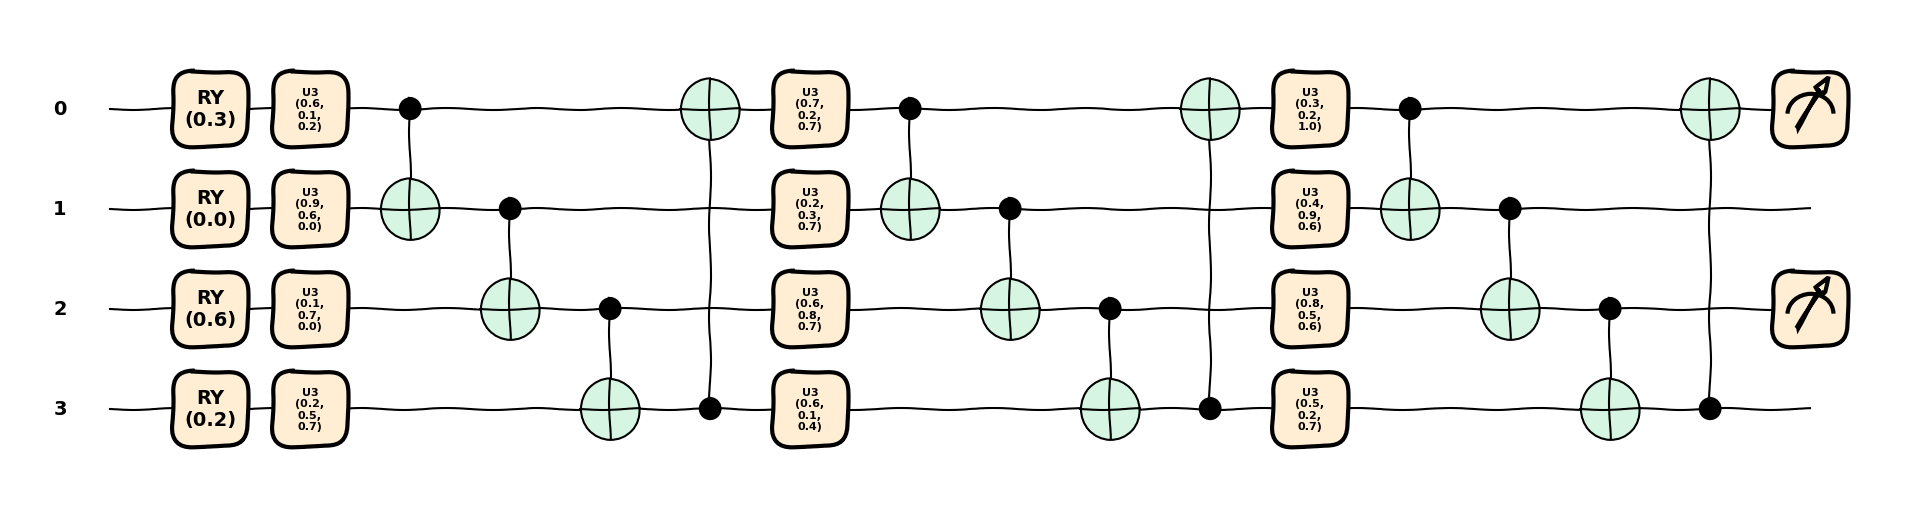

In [14]:
Xin_input,Yin_output=bsm_iv_generator(num_sample = 50,tao_bound=[0.5,0.6],  sigma_bound=[0.3,0.7], 
                                      money_bound=[0.98,1.02], rr_bound=[0.03,0.08],callput='call')

#check the data value range on each dimension
## xin = [maturity time, Stock price, interest rate, dividend, option value]

xlabel =  ['maturity time', 'Stock price', 'interest rate','option value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(Xin_input[:,i]),np.max(Xin_input[:,i]))
    
print('sigma range:')
print(np.min(Yin_output),np.max(Yin_output))
print(np.shape(Xin_input))

# generate and shuffle the data set into training and test part
xtv_train_log_all,ytv_train_log_all=logscale_vol(Xin_input,Yin_output,otm_lower=1e-4)
'''
for i in range(4):
    xtv_train_log_all[:,i]= min_max_normalization(xtv_train_log_all[:,i])
'''
#ytv_train_log_all=ytv_train_log_all/2
xtv_train_log,xtv_test_log, ytv_train_log, ytv_test_log   = train_test_split(xtv_train_log_all,ytv_train_log_all,test_size=0.2,random_state=42)

xlabel =  ['maturity time', 'Stock price', 'interest rate','time option-value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(xtv_train_log_all[:,i]),np.max(xtv_train_log_all[:,i]))
    
print('sigma range:')
print(np.min(ytv_train_log),np.max(ytv_train_log))
## how many samples after cleaning
print(np.shape(xtv_train_log))


params = npp.random.random([36], requires_grad=True)
inputs = npp.random.random([4], requires_grad=True)
print("Parameters:", params)
print("inputs:", inputs)
print("Expectation value:", circuit(params,inputs))


qnode = qml.QNode(circuit, dev)
qml.draw_mpl(circuit, decimals=1, style="sketch")(params,inputs)
plt.show()

In [15]:
def parameter_shift_term(qnode,params,inputs, i):
    shifted = params.copy()
    shifted[i] += np.pi/2
    forward = qnode(shifted,inputs)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted,inputs) # backward evaluation

    return 0.5 * (forward - backward)

# gradient with respect to the first parameter
print(parameter_shift_term(circuit,params,inputs, 0))


def parameter_shift(qnode, params,inputs):
    gradients = np.zeros([len(params)])

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode,params,inputs, i)

    return gradients

print(parameter_shift(circuit, params,inputs))

grad_function = qml.grad(circuit)
print(grad_function(params,inputs)[0])


print(qml.gradients.param_shift(circuit)(params,inputs)[0])

0.24459440697514834
[ 0.24459441 -0.20793199 -0.07980557 -0.09319043  0.08532494  0.00262219
  0.01295689  0.27317737  0.24187928 -0.2452186   0.0466584   0.03685238
  0.02108961  0.01485259  0.20831862 -0.28900479 -0.10656261 -0.14111772
 -0.03651045  0.03915074 -0.05452933 -0.06112285 -0.03461644  0.04901855
  0.0589339   0.06682056  0.00243636  0.12273512  0.23124333  0.17568448
  0.04193248 -0.0565683  -0.09406362  0.11378298  0.35554483  0.32392658]
[ 0.24459441 -0.20793199 -0.07980557 -0.09319043  0.08532494  0.00262219
  0.01295689  0.27317737  0.24187928 -0.2452186   0.0466584   0.03685238
  0.02108961  0.01485259  0.20831862 -0.28900479 -0.10656261 -0.14111772
 -0.03651045  0.03915074 -0.05452933 -0.06112285 -0.03461644  0.04901855
  0.0589339   0.06682056  0.00243636  0.12273512  0.23124333  0.17568448
  0.04193248 -0.0565683  -0.09406362  0.11378298  0.35554483  0.32392658]
[ 0.24459441 -0.20793199 -0.07980557 -0.09319043  0.08532494  0.00262219
  0.01295689  0.27317737  0.2

In [16]:
from sklearn import metrics
from itertools import chain
import time
def QNN(weights, angles):
    return circuit(weights, angles)

def cost(weights, features, labels):
    predictions = [QNN(weights, f) for f in features]
    
    return square_loss(labels, predictions)

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def R2(labels, predictions):

    r2 = 0
    for l, p in zip(labels, predictions):
        r2 = r2 + metrics.r2_score(labels, predictions)
    r2 = r2 / len(labels)

    return r2

In [17]:
X=xtv_train_log
Y=ytv_train_log
weights_init = npp.random.random([36], requires_grad=True)
opt = qml.AdamOptimizer(0.01)
batch_size = 20
batches = len (X) // batch_size
X_batches = npp.array_split(npp.arange(len(X)) , batches)


epoch 1
-------------------------------
batch_idx: 0 loss: 0.20189948434190685 R2: -13.267851017706906 time: 1703162982.1344273
batch_idx: 1 loss: 0.16993469107128428 R2: -10.55400655153858 time: 1703162998.5824156
Training [0%] Loss: 0.18591708770659557 time: 1703162998.5824156
weight: [ 0.62206743  0.06427221  0.18093823  0.91847003  0.62642714  0.02919375
  0.08149478  0.64370277 -0.01470422  0.18075592  0.52873504  0.67191728
  0.63240753  0.20425957  0.69217067  0.25720884  0.34535957  0.7664421
  0.66961488  0.82927598  0.6775589   0.54833874  0.0736717   0.34774388
  0.27733722  0.26393871  0.99296711  0.37314656  0.87206381  0.61115098
  0.77482325  0.48266452  0.55692816  0.51252077  0.17528538  0.7025018 ]
epoch 2
-------------------------------
batch_idx: 0 loss: 0.1280031851284919 R2: -8.131243141227689 time: 1703163014.6170363
batch_idx: 1 loss: 0.10448915437392567 R2: -6.021519789290577 time: 1703163030.8606641
Training [1%] Loss: 0.11624616975120879 time: 1703163030.8606

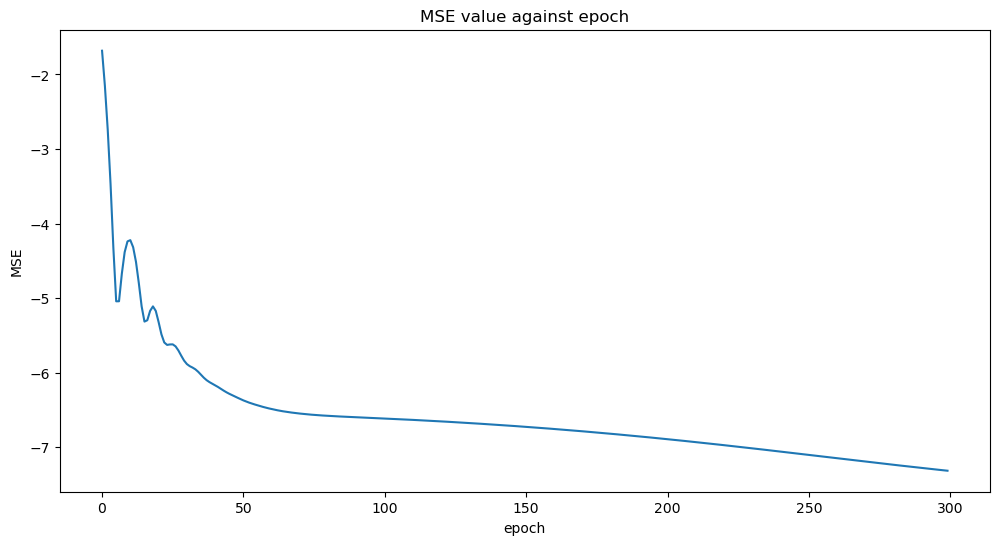

In [18]:

weights = params
loss_list=[]
r2_list=[]

n_epochs=300

start_time=time.time()
for epoch in range(n_epochs):
    total_loss  = []
    total_r2  = []
    print(f"epoch {epoch+1}\n-------------------------------")
    for it, batch_index in enumerate (chain(*[X_batches])):
        # Update the weights by one optimizer step
        
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        weights, _, _ = opt.step(cost, weights, X_batch, Y_batch)

        # Compute accuracy
        predictions = [QNN(weights, x) for x in X]
        r2 = R2(Y, predictions)
        cost_t=cost(weights,X_batch,Y_batch)
        total_loss.append(cost_t)
        total_r2.append(r2)
        end_timet=time.time()
        print("batch_idx:",it,"loss:",cost_t,"R2:",r2,"time:",end_timet)
    loss_list.append(sum(total_loss)/len(total_loss))
    r2_list.append(sum(total_r2)/len(total_r2))
    print('Training [{:.0f}%]'.format(100. * (epoch + 1) / n_epochs),"Loss:", loss_list[-1], "time:",end_timet)
    print("weight:",weights)
    
    
predictions = [QNN(weights, x) for x in X]

train_R2 = R2(Y, predictions)
train_MSE=metrics.mean_squared_error(Y,predictions)
train_RMSE=train_MSE**(1/2)
train_MAE=metrics.mean_absolute_error(Y,predictions)
train_MAPE=metrics.mean_absolute_percentage_error(Y,predictions)

print("train_MSE:",train_MSE)
print("train_RMSE:",train_RMSE)
print("train_MAE:",train_MAE)
print("train_MAPE:",train_MAPE)
print("train_R2:",train_R2)

plt.rcParams["figure.figsize"] = (12, 6)

plt.title("MSE value against epoch")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.plot(range(len(loss_list)), np.log(loss_list))
plt.show()

epoch 1
-------------------------------
batch_idx: 0 loss: 0.0006040535952201026 R2: 0.9655522320241332 time: 1703175686.0423539
batch_idx: 1 loss: 0.0003845885820608883 R2: 0.9655909508632725 time: 1703175699.500357
Training [1%] Loss: 0.0004943210886404955 time: 1703175699.500357
weight: [ 0.36348771  0.26587026  0.63001619  1.03312101  0.57642352  0.16803998
 -0.11993158  0.18214544 -0.73848203 -0.13539125  0.05288448  0.36841622
  0.51782521 -0.22370283  1.05548157  0.81403515  0.48246874  0.97633212
  1.11575839  0.91058687  0.71166334  0.37215768 -0.48470282  0.05464831
  0.63603099  0.7167963   1.32164046  0.76380255  0.97429868  0.60338166
  0.51627757  0.28085561  0.35203806  1.09206218  0.03416023  0.55437782]
epoch 2
-------------------------------
batch_idx: 0 loss: 0.000602782336748235 R2: 0.9656244045045591 time: 1703175712.634354
batch_idx: 1 loss: 0.00038379356163505314 R2: 0.9656628651601771 time: 1703175725.7489407
Training [2%] Loss: 0.0004932879491916441 time: 17031

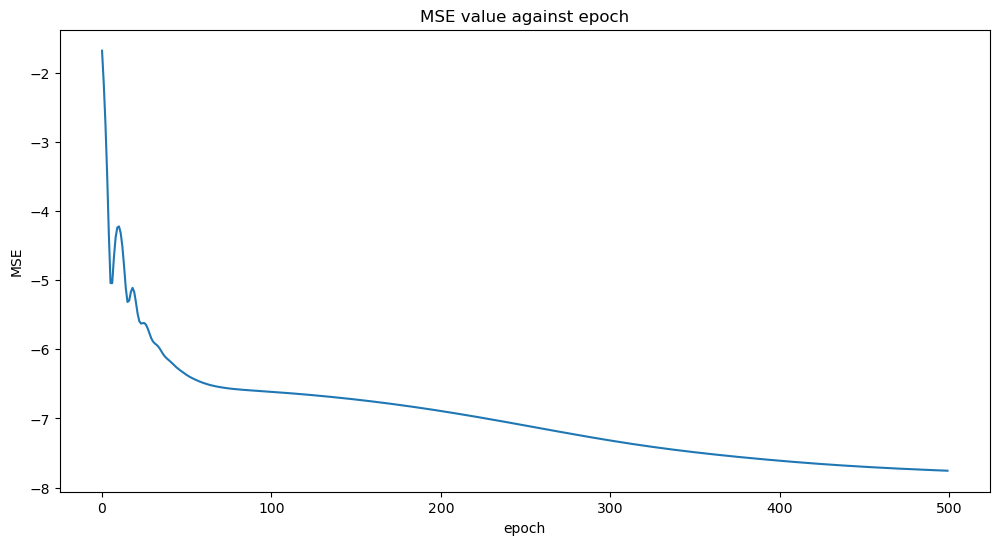

In [20]:
n_epochs=100

start_time=time.time()
for epoch in range(n_epochs):
    total_loss  = []
    total_r2  = []
    print(f"epoch {epoch+1}\n-------------------------------")
    for it, batch_index in enumerate (chain(*[X_batches])):
        # Update the weights by one optimizer step
        
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        weights, _, _ = opt.step(cost, weights, X_batch, Y_batch)

        # Compute accuracy
        predictions = [QNN(weights, x) for x in X]
        r2 = R2(Y, predictions)
        cost_t=cost(weights,X_batch,Y_batch)
        total_loss.append(cost_t)
        total_r2.append(r2)
        end_timet=time.time()
        print("batch_idx:",it,"loss:",cost_t,"R2:",r2,"time:",end_timet)
    loss_list.append(sum(total_loss)/len(total_loss))
    r2_list.append(sum(total_r2)/len(total_r2))
    print('Training [{:.0f}%]'.format(100. * (epoch + 1) / n_epochs),"Loss:", loss_list[-1], "time:",end_timet)
    print("weight:",weights)
    
    
predictions = [QNN(weights, x) for x in X]

train_R2 = R2(Y, predictions)
train_MSE=metrics.mean_squared_error(Y,predictions)
train_RMSE=train_MSE**(1/2)
train_MAE=metrics.mean_absolute_error(Y,predictions)
train_MAPE=metrics.mean_absolute_percentage_error(Y,predictions)

print("train_MSE:",train_MSE)
print("train_RMSE:",train_RMSE)
print("train_MAE:",train_MAE)
print("train_MAPE:",train_MAPE)
print("train_R2:",train_R2)

plt.rcParams["figure.figsize"] = (12, 6)

plt.title("MSE value against epoch")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.plot(range(len(loss_list)), np.log(loss_list))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

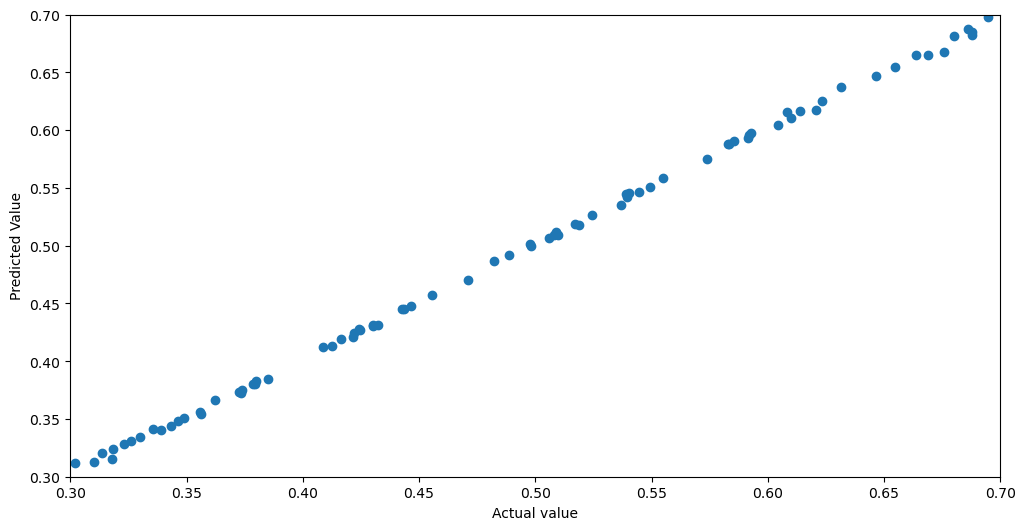

In [81]:

plt.scatter(Y,predictions)
plt.xlim(0.3,0.7)
plt.ylim(0.3,0.7)
plt.xlabel("Actual value")
plt.ylabel("Predicted Value")
plt.show

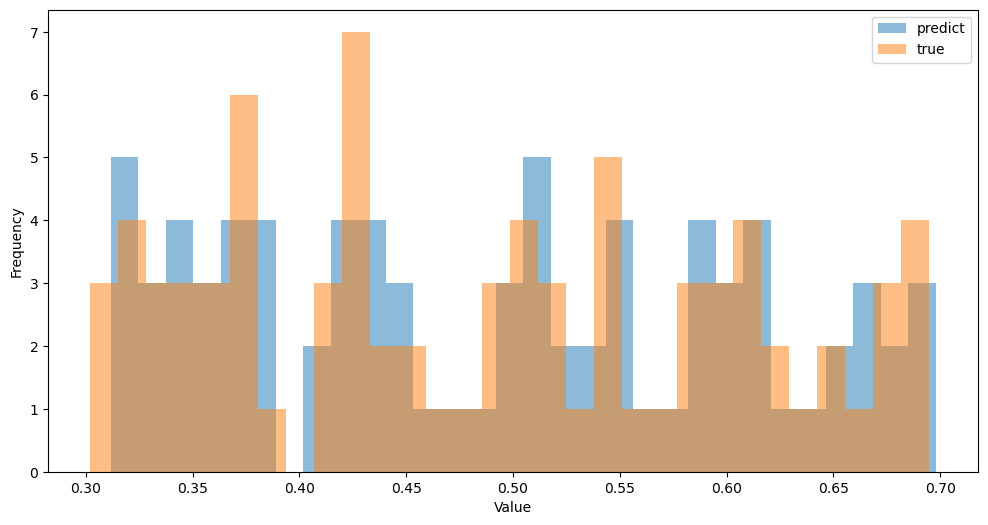

In [82]:
plt.hist(predictions, bins=30, alpha=0.5, label='predict')
plt.hist(Y, bins=30, alpha=0.5, label='true')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [83]:
print(predictions)
print(Y)

[array(0.66503768), array(0.65439535), array(0.38250689), array(0.32076478), array(0.69797685), array(0.37266672), array(0.35124215), array(0.51208905), array(0.58806803), array(0.31174841), array(0.68523296), array(0.50926333), array(0.43159983), array(0.53486923), array(0.52689814), array(0.36625563), array(0.35411562), array(0.51867633), array(0.62542668), array(0.42135334), array(0.37505925), array(0.68782943), array(0.64657654), array(0.50132936), array(0.50650567), array(0.41910647), array(0.55122823), array(0.61661481), array(0.63706712), array(0.38457162), array(0.48687178), array(0.54183732), array(0.50950446), array(0.575146), array(0.54544755), array(0.44495591), array(0.32818349), array(0.41317567), array(0.42473445), array(0.49230828), array(0.34110335), array(0.3436662), array(0.54456796), array(0.66498106), array(0.68229531), array(0.61771317), array(0.42678075), array(0.33452136), array(0.41211988), array(0.47070922), array(0.34855495), array(0.50006666), array(0.315419

In [84]:
X_test=xtv_test_log
Y_test=ytv_test_log
test_predictions = [QNN(weights, x) for x in X_test]

test_R2 = R2(Y_test, test_predictions)
test_MSE=metrics.mean_squared_error(Y_test,test_predictions)
test_RMSE=test_MSE**(1/2)
test_MAE=metrics.mean_absolute_error(Y_test,test_predictions)
test_MAPE=metrics.mean_absolute_percentage_error(Y_test,test_predictions)

print("train_MSE:",test_MSE)
print("train_RMSE:",test_RMSE)
print("train_MAE:",test_MAE)
print("train_MAPE:",test_MAPE)
print("train_R2:",test_R2)

train_MSE: 8.591922008715437e-06
train_RMSE: 0.0029311980500668043
train_MAE: 0.0023696239865641927
train_MAPE: 0.005257419636945175
train_R2: 0.9994560425522959


In [85]:
X1,Y1=bsm_iv_generator(num_sample = 5000,tao_bound=[0.5,0.6],  sigma_bound=[0.3,0.7], 
                                      money_bound=[0.98,1.02], rr_bound=[0.03,0.08],callput='call')
X1,Y1=logscale_vol(X1,Y1,otm_lower=1e-4)

In [86]:

test1_predictions = [QNN(weights, x) for x in X1]

test1_R2 = R2(Y1, test1_predictions)
test1_MSE=metrics.mean_squared_error(Y1,test1_predictions)
test1_RMSE=test1_MSE**(1/2)
test1_MAE=metrics.mean_absolute_error(Y1,test1_predictions)
test1_MAPE=metrics.mean_absolute_percentage_error(Y1,test1_predictions)

print("train_MSE:",test1_MSE)
print("train_RMSE:",test1_RMSE)
print("train_MAE:",test1_MAE)
print("train_MAPE:",test1_MAPE)
print("train_R2:",test1_R2)

train_MSE: 1.3001226554512846e-05
train_RMSE: 0.003605721363959346
train_MAE: 0.0028509397482645747
train_MAPE: 0.005893336469592067
train_R2: 0.9990311575189611


<function matplotlib.pyplot.show(close=None, block=None)>

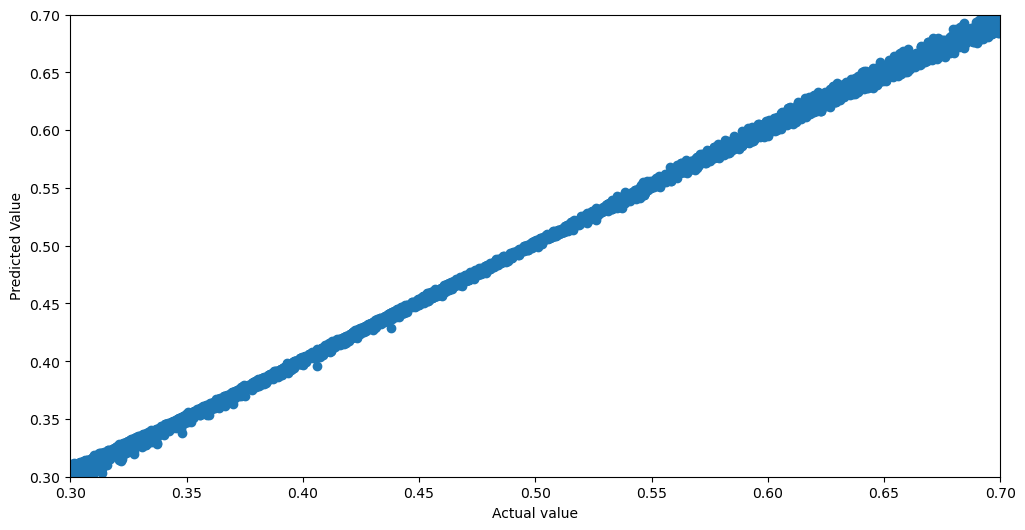

In [87]:
plt.scatter(Y1,test1_predictions)
plt.xlim(0.3,0.7)
plt.ylim(0.3,0.7)
plt.xlabel("Actual value")
plt.ylabel("Predicted Value")
plt.show